# Monte Carlo

### Train

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

def MonteCarlo(episodes, env_seed, size):

    # Initialize Frozen Lake environment
    env = gym.make("FrozenLake-v1", desc=env_seed, map_name="12x12", is_slippery=False, render_mode=None)

    # Initialize Q-table
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    Q = np.zeros((num_states, num_actions))

    # Initialize returns and visits
    returns = [[[] for _ in range(num_actions)] for _ in range(num_states)]
    visits = np.zeros((num_states, num_actions))

    # Initialize set to store visited states
    visited_states = set()

    # Exploration policy parameters
    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 1/episodes   # epsilon decay rate. 1/0.0001 = 10,000
    rng = np.random.default_rng()   # random number generator

    
    rewards_per_episode = np.zeros(episodes)

    # Monte Carlo algorithm
    for episode in range(episodes):
        state = env.reset()[0]
        episode_data = []
        done = False
        while not done:
            # Choose action using epsilon-greedy policy
            if rng.random() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[state])  # Exploit
        
            # Take action and observe next state and reward
            next_state, reward, done, _, _ = env.step(action)

            if reward == 1:
                reward = episodes
            elif done:
                reward = -1*episodes
            else:
                reward = -1

            # Store episode data
            episode_data.append((state, action, reward))

            # Transition to next state
            state = next_state

        # Calculate returns and update Q-values
        G = 0

        if reward == episodes:
            rewards_per_episode[episode] = 1

        for i, (state, action, reward) in enumerate(reversed(episode_data)):
            G += reward
            if state not in visited_states:
                returns[state][action].append(G)
                visits[state][action] += 1
                Q[state][action] = np.mean(returns[state][action])
                visited_states.add(state)  # Add visited state to set
        # Clear visited states for next episode
        visited_states.clear()

        epsilon = max(epsilon - epsilon_decay_rate, 0)

    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            if Q[i, j] == 0: 
                Q[i, j] = -1*episodes*size



    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

    plt.plot(sum_rewards, label="MonteCarlo")
    plt.legend()

    plt.savefig('images/frozen_lake_MonteCarlo.png')
    return Q

size = 8
env_seed = generate_random_map(size=size)
MonteCarlo_model = MonteCarlo(15000, env_seed, size)

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

def SARSA(episodes, env_seed):

    env = gym.make("FrozenLake-v1", desc=env_seed, map_name="12x12", is_slippery=False, render_mode=None)

    q = np.zeros((env.observation_space.n, env.action_space.n)) # init a 64 x 4 array

    learning_rate_a = 0.5 # alpha or learning rate
    discount_factor_g = 0.99 # gamma or discount rate. Near 0: more weight/reward placed on immediate state. Near 1: more on future state.
    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 1/episodes   # epsilon decay rate. 1/0.0001 = 10,000
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        if rng.random() < epsilon:
            action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
        else:
            action = np.argmax(q[state,:])
        while(not terminated and not truncated):
            new_state,reward,terminated,truncated,_ = env.step(action)
            if rng.random() < epsilon:
                new_action = env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
            else:
                new_action = np.argmax(q[new_state,:])

            if reward == 1:
                reward = 0
            elif terminated:
                reward = -99
            else:
                reward = -1

            q[state,action] = (1-learning_rate_a) * q[state,action] + learning_rate_a*(reward + discount_factor_g*q[new_state,new_action])
            state = new_state
            action = new_action

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if(epsilon==0):
            learning_rate_a = 1/episodes

        if reward == 0:
            rewards_per_episode[i] = 1
    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])

    plt.plot(sum_rewards, label="SARSA")
    plt.legend()

    plt.savefig('images/frozen_lake_SARSA.png')
    return q


env_seed = generate_random_map(size=12)
Sarsa_model = SARSA(5000, env_seed)

### Test

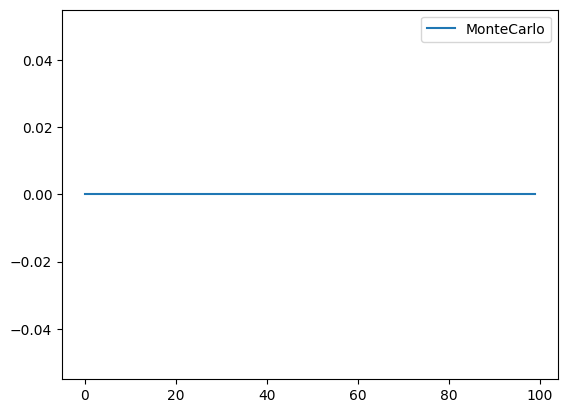

In [80]:
# MonteCarlo_model1 = MonteCarlo(15000, env_seed, size)
import FrozenLakeFunctions as flf

flf.testModel(MonteCarlo_model, "MonteCarlo", env_seed, 100)
flf.seeModel(MonteCarlo_model, env_seed)